In [22]:
import numpy as np
from glob import glob
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from tensorflow.keras.utils import image_dataset_from_directory
from sklearn.linear_model import LogisticRegression
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from skimage import exposure
from sklearn.metrics import f1_score
from pretty_confusion_matrix import pp_matrix_from_data
from sklearn import svm
import pandas as pd

In [23]:
# Get images' names
non_demented = glob('./data/Non_Demented/*.jpg')
mild_demented = glob('./data/Mild_Demented/*.jpg')
moderate_demented = glob('./data/Moderate_Demented/*.jpg')
very_mild_demented = glob('./data/Very_Mild_Demented/*.jpg')

# Note: The current mapping is that 0 = non_demented, 1 = mild_demented, 2 = moderate_demented, and 3 = very_mild_demented.

num_classes = 4
image_size = (108,108, 1)

In [24]:
def view_image(filename):
    img = mpimg.imread(filename)
    img = img[10:118, 10:118]
    plt.imshow(img)
    print(f'Image shape: {img.shape}')


Total amount of non_demented: 3200
Image shape: (108, 108)


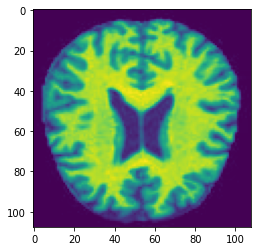

In [25]:
print(f'Total amount of non_demented: {len(non_demented)}')
view_image(non_demented[0])

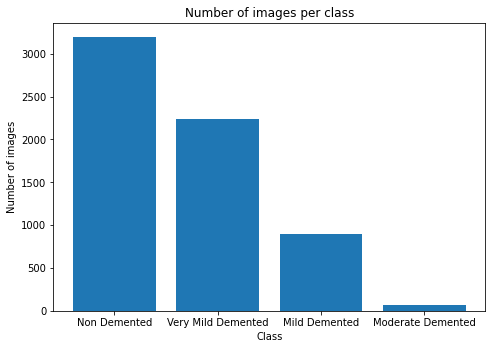

In [26]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
size = [len(non_demented), len(very_mild_demented), len(mild_demented), len(moderate_demented)]
class_names = ['Non Demented', 'Very Mild Demented', 'Mild Demented', 'Moderate Demented']
ax.bar(class_names,size)
ax.set_ylabel("Number of images")
ax.set_title("Number of images per class")
ax.set_xlabel("Class")
plt.show()

In [27]:
def extract_feature(dir_path, image_type=0):
    img = mpimg.imread(dir_path)
    img = img[10:118, 10:118] 
    gamma_img = exposure.adjust_gamma(img, 2) 
    log_img = exposure.adjust_log(img, 1)

    # photoshopping some values to avoid gpu going brrr
    if image_type == 0:
        pass 
    elif image_type == 1: # gamma
        img = gamma_img
    elif image_type == 2: # log
        img = log_img

    img = img / 255.0  # normalize pixel values
    return img
# print(extract_feature("data/Non_Demented/non.jpg"))
# 

image_type = 2

all_data =  np.array([extract_feature(filename, image_type) for filename in non_demented] + \
            [extract_feature(filename, image_type) for filename in mild_demented] + \
            [extract_feature(filename, image_type) for filename in moderate_demented] + \
            [extract_feature(filename, image_type) for filename in very_mild_demented])

y = np.array([0] * len(non_demented) + [1] * len(mild_demented) + [2] * len(moderate_demented) + [3] * len(very_mild_demented))
X_train, X_rem, y_train, y_rem = train_test_split(all_data, y, train_size = 0.8, stratify=y)
X_valid, X_test, y_valid, y_test = train_test_split(X_rem, y_rem, train_size = 0.5, stratify=y_rem)
# print(f"Length of training set: {len(X_train)}")
# print(f"Length of validation set: {len(X_valid)}")
# print(f"Length of test set: {len(X_test)}")
X_train_collapse = X_train.reshape(X_train.shape[0], -1)
X_valid_collapse = X_valid.reshape(X_valid.shape[0], -1)
X_test_collapse = X_test.reshape(X_test.shape[0], -1)
print(X_train.shape)

(5120, 108, 108)


# SVM

In [29]:
# SVM

# too much time to run it all, this will randomly sample 40% of the rows for each section (keeps proportion same as before but allows faster runtime)
train_index = np.random.choice(X_train_collapse.shape[0], int(X_train_collapse.shape[0] * 0.4), replace=False)  
valid_index = np.random.choice(X_valid_collapse.shape[0], int(X_valid_collapse.shape[0] * 0.4), replace=False) 
test_index = np.random.choice(X_test_collapse.shape[0], int(X_test_collapse.shape[0] * 0.4), replace=False) 

X_train_collapse_short = X_train_collapse[train_index, :]
X_valid_collapse_short = X_valid_collapse[valid_index, :]
X_test_collapse_short = X_test_collapse[test_index, :]

y_train_short = y_train[train_index]
y_valid_short = y_valid[valid_index]
y_test_short = y_test[test_index]

# print(X_train_collapse.shape)
print(X_train_collapse_short.shape)
print(X_valid_collapse_short.shape)
print(X_test_collapse_short.shape)

best_lambda = -1
best_kernel = "?"
highest_f1_val = -1

lambdas = [0.001, 0.01, 0.1, 1, 10]
kernels = ["linear", "poly", "rbf"]
for lamb in lambdas:
    for kern in kernels:
        print(f"lambda = {lamb}, kernel = {kern}")
        svc = svm.SVC(probability=False, C=lamb, kernel=kern)
        svc.fit(X_train_collapse_short, y_train_short) 
        yhat_train = svc.predict(X_train_collapse_short)
        yhat_val = svc.predict(X_valid_collapse_short)
        f1_train = f1_score(y_train_short, yhat_train, average='weighted')
        f1_val = f1_score(y_valid_short, yhat_val, average='weighted')

        if f1_val > highest_f1_val:
            highest_f1_val = f1_val
            best_lambda = lamb
            best_kernel = kern

        print(f'F1 Train = {f1_train:f}')
        print(f'F1 Validation = {f1_val:f}')

print(f"Best lambda: {best_lambda} and kernel: {best_kernel}")
print(f"Highest F1 Validation: {highest_f1_val:f}")
# Can try out different kernel functions - linear poly, rbf, sigmoid
# what are the different C values that are used
# confusion matrix

# svc.fit(X_train_collapse_short, y_train_short)

(2048, 11664)
(256, 11664)
(256, 11664)
lambda = 0.001, kernel = linear
F1 Train = 0.618922
F1 Validation = 0.512502
lambda = 0.001, kernel = poly
F1 Train = 0.310800
F1 Validation = 0.307622
lambda = 0.001, kernel = rbf
F1 Train = 0.310800
F1 Validation = 0.307622
lambda = 0.01, kernel = linear
F1 Train = 0.962394
F1 Validation = 0.801448
lambda = 0.01, kernel = poly
F1 Train = 0.517876
F1 Validation = 0.452107
lambda = 0.01, kernel = rbf
F1 Train = 0.310800
F1 Validation = 0.307622
lambda = 0.1, kernel = linear
F1 Train = 1.000000
F1 Validation = 0.848954
lambda = 0.1, kernel = poly
F1 Train = 0.679438
F1 Validation = 0.551024
lambda = 0.1, kernel = rbf
F1 Train = 0.491708
F1 Validation = 0.444617
lambda = 1, kernel = linear
F1 Train = 1.000000
F1 Validation = 0.848954
lambda = 1, kernel = poly
F1 Train = 0.990725
F1 Validation = 0.845040
lambda = 1, kernel = rbf
F1 Train = 0.713496
F1 Validation = 0.561225
lambda = 10, kernel = linear
F1 Train = 1.000000
F1 Validation = 0.848954
lam

In [12]:
# Some testing
# random svm testing + getting test set result
# yhat_train = svc.predict(X_train_collapse_short)
# acc = np.mean(yhat_train == y_train)
# print('Accuaracy = {0:f}'.format(acc))

# yhat_val = svc.predict(X_valid_collapse)
# acc = np.mean(yhat_val == y_valid)
# print('Accuaracy = {0:f}'.format(acc))

# yhat_test = svc.predict(X_test_collapse)
# acc = np.mean(yhat_test == y_test)
# print('Accuaracy = {0:f}'.format(acc))

train_index = np.random.choice(X_train_collapse.shape[0], int(X_train_collapse.shape[0] * 0.4), replace=False)  
valid_index = np.random.choice(X_valid_collapse.shape[0], int(X_valid_collapse.shape[0] * 0.4), replace=False) 
test_index = np.random.choice(X_test_collapse.shape[0], int(X_test_collapse.shape[0] * 0.4), replace=False) 

X_train_collapse_short = X_train_collapse[train_index, :]
X_valid_collapse_short = X_valid_collapse[valid_index, :]
X_test_collapse_short = X_test_collapse[test_index, :]

y_train_short = y_train[train_index]
y_valid_short = y_valid[valid_index]
y_test_short = y_test[test_index]

svc = svm.SVC(probability=False, C=10, kernel="rbf")
svc.fit(X_train_collapse_short, y_train_short) 
yhat_test = svc.predict(X_test_collapse_short)
f1_test = f1_score(y_test_short, yhat_test, average='weighted')
print(f"F1 Test: {f1_test}")

F1 Test: 0.905609111460466


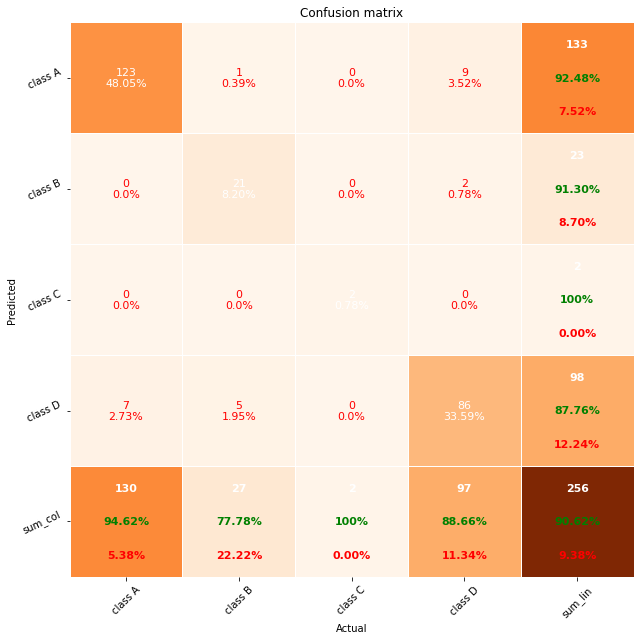

In [14]:
# Confusion Matrix for SVM
pp_matrix_from_data(y_test_short, yhat_test)

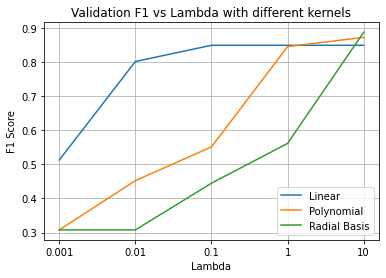

In [45]:
# svm plots
lambdas = [0.001, 0.01, 0.1, 1, 10]

#training
lin_train = [0.618922, 0.962394, 1, 1, 1]
poly_train = [0.3108, 0.517876, 0.679438, 0.990725, 1]
rbf_train = [0.3108, 0.3108, 0.491708, 0.713496, 0.998046]

#validation 
lin_val = [0.512502, 0.801448, 0.848954, 0.848954, 0.848954] 
poly_val = [0.307622, 0.452107, 0.551024, 0.84504, 0.872095]
rbf_val = [0.307622, 0.307622, 0.444617, 0.561225, 0.887164]

plt.ticklabel_format(axis="x", style="sci", scilimits=(0, 0))
default_x_ticks = range(len(lambdas))

# plt.title("Training F1 vs Lambda with different kernels")
# plt.plot(default_x_ticks, lin_train, label="Linear")
# plt.plot(default_x_ticks, poly_train, label="Polynomial")
# plt.plot(default_x_ticks, rbf_train, label="Radial Basis")


plt.title("Validation F1 vs Lambda with different kernels")
plt.plot(default_x_ticks, lin_val, label="Linear")
plt.plot(default_x_ticks, poly_val, label="Polynomial")
plt.plot(default_x_ticks, rbf_val, label="Radial Basis")

plt.xticks(default_x_ticks, lambdas)
plt.xlabel("Lambda")
plt.ylabel("F1 Score")
plt.grid()
plt.legend()
plt.show()


# Logistic Regression

In [7]:
# Logistic Regression
# Logistic Regression
# Train all, then find best hyperparameter based on validatoin set, and use that to get test set answer

# print(X_train_collapse.shape)
# print(X_valid_collapse.shape) 
# print(X_test_collapse.shape)
# print(y_train.shape)
# print(y_valid.shape)
# print(y_test.shape)

lambdas = [0.001, 0.01, 0.1, 1, 10]
regularization = ["none", "l2"]

best_lambda = -1
best_regularization = -1
highest_f1_val = -1

# First on no image, evaluate on training and validation, then at the end test
for lamb in lambdas:
        for reg in regularization:
                # max iterations set to 50 to speed it up
                logreg = LogisticRegression(max_iter=50, multi_class="multinomial", solver="sag", penalty=reg, C=lamb) #because I used sag, can't do l1
                logreg.fit(X_train_collapse, y_train)
                print(f'Lambda: {lamb}, Regularization: {reg}')

                yhat_train = logreg.predict(X_train_collapse) 
                yhat_val = logreg.predict(X_valid_collapse)
                # acc = np.mean(yhat_train == y_train)
                #using f1, just hvae accuracy for now
                f1_train = f1_score(y_train, yhat_train, average='weighted')
                f1_val = f1_score(y_valid, yhat_val, average='weighted')
                if f1_val > highest_f1_val:
                    highest_f1_val = f1_val
                    best_lambda = lamb
                    best_regularization = reg
                print(f'F1 Train = {f1_train:f}')
                print(f'F1 Validation = {f1_val:f}')

# we only run once on the test set after getting best model from validation (I got value from before)

print(f"Best Parameters: Lambda: {best_lambda}, Regularization: {best_regularization}")
logreg = LogisticRegression(max_iter=50, multi_class="multinomial", solver="sag", penalty=best_regularization, C=best_lambda)
logreg.fit(X_train_collapse, y_train)
yhat_test = logreg.predict(X_test_collapse)
f1_test = f1_score(y_test, yhat_test, average='weighted')
print(f'F1 Test = {f1_test:f}')
    
#used sag solver, set iterations to 50, will show ROC curve why not 

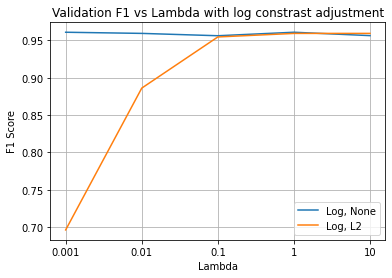

In [42]:
# Logreg plots
from sklearn.metrics import roc_curve
from matplotlib import ticker

lambdas = [0.001, 0.01, 0.1, 1, 10]
regularization = ["none", "l2"]
#training
default_none_train = [0.997265, 0.99707, 0.99707, 0.99707, 0.997265]
default_l2_train = [0.736764, 0.951198, 0.99492, 0.996874, 0.99707]
gamma_none_train = [0.999219, 0.999219, 0.999219, 0.999414, 0.999219]
gamma_l2_train = [0.742283, 0.950409, 0.99707, 0.999219, 0.999219]
log_none_train = [0.994725, 0.995311, 0.994725, 0.995116, 0.996289]
log_l2_train = [0.741067, 0.948225, 0.993552, 0.995311, 0.995312]

#validation
default_none_val = [0.937506, 0.940622, 0.939093, 0.939093, 0.939034]
default_l2_val = [0.680166, 0.866417, 0.932734, 0.942208, 0.939034]
gamma_none_val = [0.94349, 0.941899, 0.943437, 0.94349, 0.943443]
gamma_l2_val = [0.691311, 0.859182, 0.935649, 0.941939, 0.940344]
log_none_val= [0.960959, 0.959423, 0.956276, 0.960959, 0.956425]
log_l2_val = [0.696147, 0.886115, 0.954659, 0.959386, 0.959423]

plt.ticklabel_format(axis="x", style="sci", scilimits=(0, 0))
default_x_ticks = range(len(lambdas))
# plt.title("Training F1 vs Lambda with no constrast adjustment")
# plt.plot(default_x_ticks, default_none_train, label="Default, None")
# plt.plot(default_x_ticks , default_l2_train, label="Default, L2")

# plt.title("Training F1 vs Lambda with gamma constrast adjustment")
# plt.plot(default_x_ticks, gamma_none_train, label="Gamma, None")
# plt.plot(default_x_ticks, gamma_l2_train, label="Gamma, L2")

# plt.title("Training F1 vs Lambda with log constrast adjustment")
# plt.plot(default_x_ticks, log_none_train, label="Log, None")
# plt.plot(default_x_ticks, log_l2_train, label="Log, L2")

# plt.title("Validation F1 vs Lambda with no constrast adjustment")
# plt.plot(default_x_ticks, default_none_val, label="Default, None")
# plt.plot(default_x_ticks , default_l2_val, label="Default, L2")

# plt.title("Validation F1 vs Lambda with gamma constrast adjustment")
# plt.plot(default_x_ticks, gamma_none_val, label="Gamma, None")
# plt.plot(default_x_ticks, gamma_l2_val, label="Gamma, L2")

# plt.title("Validation F1 vs Lambda with log constrast adjustment")
# plt.plot(default_x_ticks, log_none_val, label="Log, None")
# plt.plot(default_x_ticks, log_l2_val, label="Log, L2")

plt.xticks(default_x_ticks, lambdas)
plt.xlabel("Lambda")
plt.ylabel("F1 Score")
plt.grid()
plt.legend()
plt.show()
# do ROC curve on the test set
# roc_curve(y_test, yhat_test)


In [ ]:
# Confusion Matrix for logreg 
logreg = LogisticRegression(max_iter=50, multi_class="multinomial", solver="sag", penalty="none", C=0.001) 
logreg.fit(X_train_collapse, y_train)
yhat_test = logreg.predict(X_test_collapse) 

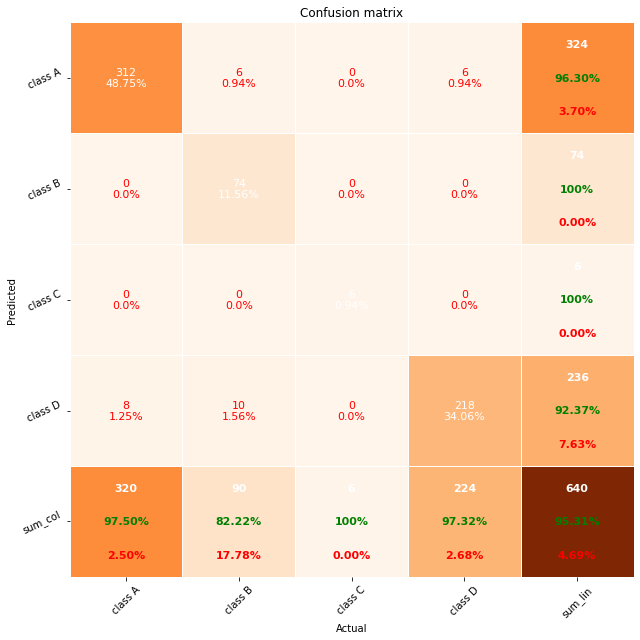

In [59]:
pp_matrix_from_data(y_test, yhat_test)

# A cool model
First layer: Convolution with 32 filters of 3x3 squares <br/>
Second layer: leaky RELU for activation <br/>
Third layer: Max of 2x2 squares <br/>
Fourth layer: Convolution with 64 filters of 3x3 squares <br/>
Fifth layer: Leaky again <br/>
Sixth layer: Max of 2x2 squares <br/>
7thth layer: Flatten all 3 channels <br/>
8th - 10th: Fully connected neural network through Dense <br/>
Adding regularization through Dropout and L2 <br/>

In [8]:
# Neural Networks (CNN)
from tensorflow import keras 
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.advanced_activations import LeakyReLU
from sklearn.metrics import classification_report

In [13]:
learn_rate = 0.001

noreg_model = Sequential()
noreg_model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',input_shape=image_size,padding='same'))
noreg_model.add(LeakyReLU(alpha=0.1))
noreg_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))

noreg_model.add(Conv2D(64, (3, 3), activation='linear', padding='same'))
noreg_model.add(LeakyReLU(alpha=0.1))
noreg_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))

noreg_model.add(Flatten())
noreg_model.add(Dense(128, activation='linear'))
noreg_model.add(LeakyReLU(alpha=0.1))
noreg_model.add(Dense(num_classes, activation='softmax'))

noreg_model.compile(loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=learn_rate),metrics=['accuracy'])
print(noreg_model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 108, 108, 32)      320       
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 108, 108, 32)      0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 54, 54, 64)        18496     
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 54, 54, 64)        0         
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 27, 27, 64)       0         
 2D)                                                  

In [14]:
# train_index = np.random.choice(X_train.shape[0], int(X_train.shape[0] * 0.4), replace=False)  
# valid_index = np.random.choice(X_valid.shape[0], int(X_valid.shape[0] * 0.4), replace=False) 
# test_index = np.random.choice(X_test.shape[0], int(X_test.shape[0] * 0.4), replace=False) 

# X_train_short = X_train[train_index, :]
# X_valid_short = X_valid[valid_index, :]
# X_test_short = X_test[test_index, :]
# print(X_train_short.shape)

# y_train_short = y_train[train_index]
# y_valid_short = y_valid[valid_index]
# y_test_short = y_test[test_index]


In [10]:
l2_lambda=0.01
learn_rate = 0.001

reg_model = Sequential()
reg_model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',input_shape=image_size,padding='same'))
reg_model.add(LeakyReLU(alpha=0.1))
reg_model.add(Dropout(0.2))
reg_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))

reg_model.add(Conv2D(64, (3, 3), activation='linear', kernel_regularizer=keras.regularizers.l2(l=l2_lambda), padding='same'))
reg_model.add(LeakyReLU(alpha=0.1))
reg_model.add(Dropout(0.2))
reg_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))

reg_model.add(Flatten())
reg_model.add(Dense(128, activation='linear', kernel_regularizer=keras.regularizers.l2(l=l2_lambda)))
reg_model.add(LeakyReLU(alpha=0.1))       
reg_model.add(Dropout(0.2))
reg_model.add(Dense(num_classes, activation='softmax'))

reg_model.compile(loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=learn_rate),metrics=['accuracy'])
print(reg_model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 108, 108, 32)      320       
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 108, 108, 32)      0         
                                                                 
 dropout (Dropout)           (None, 108, 108, 32)      0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 54, 54, 64)        18496     
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 54, 54, 64)        0         
                                                      

In [14]:
noreg_model_train = noreg_model.fit(X_train, y_train, batch_size=1600,epochs=20,verbose=1,validation_data=(X_valid, y_valid))

Epoch 1/20
4/4 [==============================] - 39s 9s/step - loss: 3.1836 - accuracy: 0.2902 - val_loss: 1.2887 - val_accuracy: 0.5000
Epoch 2/20
4/4 [==============================] - 39s 9s/step - loss: 1.5431 - accuracy: 0.5000 - val_loss: 1.1514 - val_accuracy: 0.5141
Epoch 3/20
4/4 [==============================] - 36s 8s/step - loss: 1.2199 - accuracy: 0.3928 - val_loss: 1.1058 - val_accuracy: 0.5688
Epoch 4/20
4/4 [==============================] - 40s 9s/step - loss: 1.0819 - accuracy: 0.5191 - val_loss: 1.0555 - val_accuracy: 0.5000
Epoch 5/20
4/4 [==============================] - 44s 10s/step - loss: 1.0299 - accuracy: 0.5004 - val_loss: 1.0343 - val_accuracy: 0.5188
Epoch 6/20
4/4 [==============================] - 46s 11s/step - loss: 1.0183 - accuracy: 0.5055 - val_loss: 1.0136 - val_accuracy: 0.5000
Epoch 7/20
4/4 [==============================] - 40s 9s/step - loss: 1.0058 - accuracy: 0.5211 - val_loss: 1.0050 - val_accuracy: 0.5156
Epoch 8/20
4/4 [================

In [28]:
noreg_y_pred = noreg_model.predict(X_test, batch_size=64, verbose=1)
y_pred_bool = np.argmax(noreg_y_pred, axis=1)
f1_score = f1_score(y_test, y_pred_bool, average='weighted')
print(f"F1 Score: {f1_score}")
print(classification_report(y_test, y_pred_bool, zero_division=1))

10/10 [==============================] - 1s 128ms/step
F1 Score: 0.5752029501000264
              precision    recall  f1-score   support

           0       0.65      0.83      0.73       320
           1       0.67      0.20      0.31        90
           2       1.00      0.00      0.00         6
           3       0.50      0.46      0.47       224

    accuracy                           0.60       640
   macro avg       0.70      0.37      0.38       640
weighted avg       0.60      0.60      0.58       640



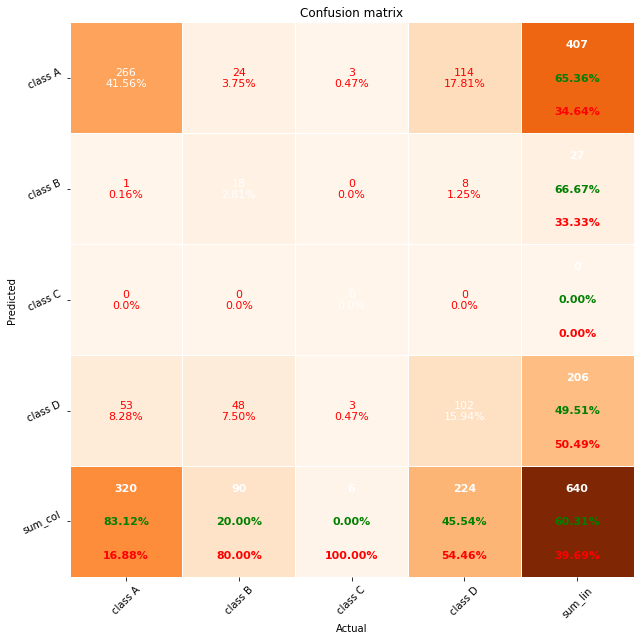

In [30]:
pp_matrix_from_data(y_test, y_pred_bool)

In [11]:
reg_model_train = reg_model.fit(X_train, y_train, batch_size=1600,epochs=20,verbose=1,validation_data=(X_valid, y_valid))

Epoch 1/20
4/4 [==============================] - 92s 16s/step - loss: 5.3176 - accuracy: 0.3697 - val_loss: 3.2632 - val_accuracy: 0.3500
Epoch 2/20
4/4 [==============================] - 71s 17s/step - loss: 3.3482 - accuracy: 0.3324 - val_loss: 2.5738 - val_accuracy: 0.5000
Epoch 3/20
4/4 [==============================] - 68s 16s/step - loss: 2.4954 - accuracy: 0.4969 - val_loss: 2.4956 - val_accuracy: 0.5000
Epoch 4/20
4/4 [==============================] - 61s 14s/step - loss: 2.3220 - accuracy: 0.5018 - val_loss: 2.2273 - val_accuracy: 0.3500
Epoch 5/20
4/4 [==============================] - 64s 15s/step - loss: 2.1500 - accuracy: 0.4467 - val_loss: 2.0905 - val_accuracy: 0.5000
Epoch 6/20
4/4 [==============================] - 58s 13s/step - loss: 2.0076 - accuracy: 0.5006 - val_loss: 1.9113 - val_accuracy: 0.5000
Epoch 7/20
4/4 [==============================] - 57s 13s/step - loss: 1.8645 - accuracy: 0.4986 - val_loss: 1.8146 - val_accuracy: 0.5000
Epoch 8/20
4/4 [===========

In [12]:
y_pred = reg_model.predict(X_test, batch_size=64, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

print(classification_report(y_test, y_pred_bool, zero_division=1))

10/10 [==============================] - 2s 126ms/step
              precision    recall  f1-score   support

           0       0.57      0.91      0.70       320
           1       0.48      0.17      0.25        90
           2       1.00      0.00      0.00         6
           3       0.50      0.22      0.30       224

    accuracy                           0.55       640
   macro avg       0.64      0.32      0.31       640
weighted avg       0.54      0.55      0.49       640



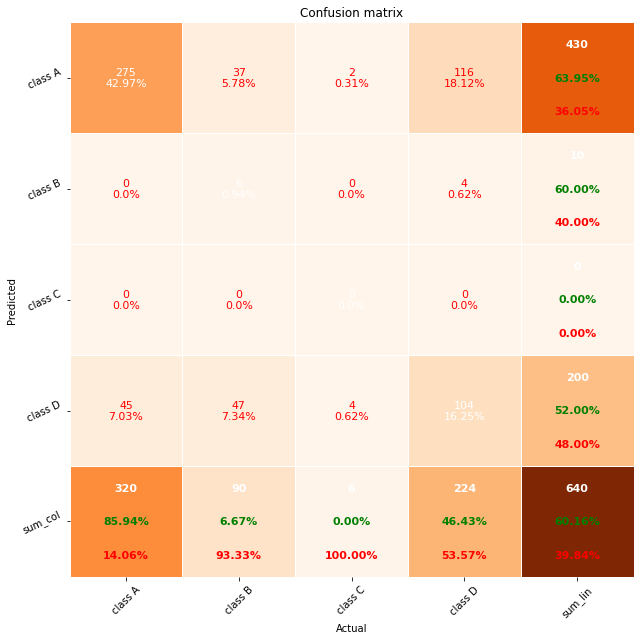

In [18]:
pp_matrix_from_data(y_test, y_pred_bool)

# Visualizing performance over iterations
The model runs for 20 iterations. This section will plot both models' accuracy and cross-entropy errors over both the training set and validation set during all 20 iterations.

In [17]:
noreg_accuracy = noreg_model_train.history['accuracy']
noreg_val_accuracy = noreg_model_train.history['val_accuracy']
reg_accuracy = reg_model_train.history['accuracy']
reg_val_accuracy = reg_model_train.history['val_accuracy']

noreg_loss = noreg_model_train.history['loss']
noreg_val_loss = noreg_model_train.history['val_loss']
reg_loss = reg_model_train.history['loss']
reg_val_loss = reg_model_train.history['val_loss']

plt.plot(iterations, noreg_accuracy, 'bo', label='Training accuracy w/o reg')
plt.plot(iterations, noreg_val_accuracy, 'b', label='Validation accuracy w/o reg')
plt.plot(iterations, reg_accuracy, 'ro', label='Training accuracy w/ reg')
plt.plot(iterations, reg_val_accuracy, 'r', label='Validation accuracy w/ reg')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(iterations, noreg_loss, 'bo', label='Training loss w/o reg')
plt.plot(iterations, noreg_val_loss, 'b', label='Validation loss w/o reg')
plt.plot(iterations, reg_loss, 'ro', label='Training loss w/ reg')
plt.plot(iterations, reg_val_loss, 'r', label='Validation loss w/ reg')
plt.title('Training and validation loss')
plt.legend()
plt.show()

KeyError: 'f1_score'

# Visualizing the filters
To get a better understanding of what the weights look like inside the filters of a CNN layer, we can plot their weight as grayscale.
Then, dark will means small weights and white will means large weights.
In that sense, we can get an intuition of the patterns that each CNN layer is trying to identify.

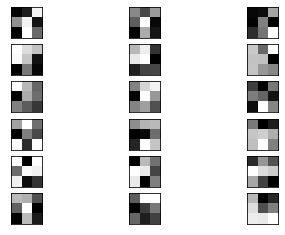

In [24]:
# Visualize the filters. Dark = small weights, light = large weights

filters, biases = noreg_model.layers[0].get_weights()
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

# plot first 18 filters
n_filters, ix = 6, 1
for i in range(n_filters):
    f = filters[:, :, :, i]
    # plot each channel separately
    for j in range(3):
        ax = plt.subplot(n_filters, 3, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        plt.imshow(f[:, :, j], cmap='gray')
        ix += 1
        
plt.show()

# Visualizing how the filter applies to an example image
It can be hard to know what exactly all the filters in the CNN layers are trying to extract.
By applying the same transformation of one layer to an example input, we can see what kind of features each filters are trying to identify (background, certain edges,...)

Showing image #1307: Non Demented


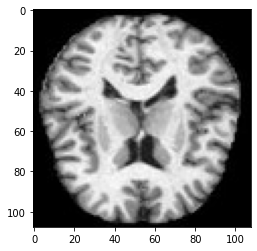

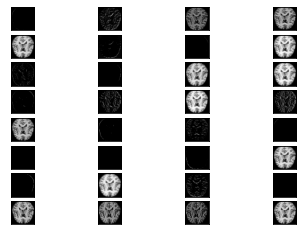

In [28]:
# Visualize how the filter apply to an example image

from keras.models import Model
import random
from numpy import expand_dims

filter_model = Model(inputs=noreg_model.inputs, outputs=noreg_model.layers[0].output)

# get a random image
idx = random.randint(0, len(all_data) - 1)
sample_img = all_data[idx]
plt.imshow(sample_img)
print(f"Showing image #{idx}: {class_names[y[idx]]}")
sample_img = expand_dims(sample_img, axis=0)
feature_map = filter_model.predict(sample_img)

plt.figure()
# Plot on 4x8
ix = 1
for i in range(8):
    for j in range(4):
        ax = plt.subplot(8, 4, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        plt.imshow(feature_map[0, :, :, ix-1], cmap='gray')
        ix += 1
# show the figure
plt.show()

# For fun and giggle, we add PCA to see how many features are actually relevant
Since some part of the images are eternally dark and is useless, we use PCA to see how much features are actually relevant

Number of components explaining 80% variance: 175


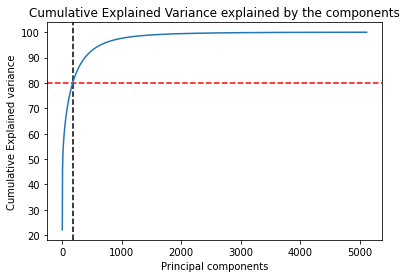

In [34]:
# For more fun, do PCA
from sklearn import decomposition

X_train_pca = X_train.reshape(X_train.shape[0], np.product(X_train.shape[1:]))
pca = decomposition.PCA(5120)
X_proj = pca.fit_transform(X_train_pca)
cumulative_variance = np.cumsum(pca.explained_variance_ratio_) * 100

k = np.argmax(cumulative_variance > 80)
print(f"Number of components explaining 80% variance: {k}")

# Plot the cumulative variance
plt.title('Cumulative Explained Variance explained by the components')
plt.ylabel('Cumulative Explained variance')
plt.xlabel('Principal components')
plt.axvline(x=k, color="k", linestyle="--")
plt.axhline(y=80, color="r", linestyle="--")
plt.plot(cumulative_variance)
plt.show()

# For fun and memeing purpose, showing the average MRI brain scan
Because we're bored, we decide to average every images and show the "average" MRI brain scan

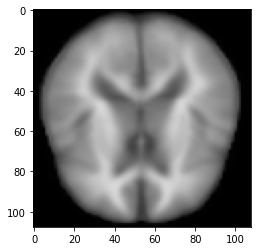

In [35]:
# FOR EVEN MORE FUN, get the average brain scan
average_img = np.average(all_data, axis = 0)
plt.imshow(average_img)